# Helper functions

In [25]:
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np


def hash_sensor_order(order):
    hash = 0
    for i in range(4):
        hash += order[i] * 4 ** i
    return hash


def show_pose(t_vec, r_matrix):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(-2, 2)
    
    # Plot geom
    point = (t_vec[0], t_vec[1], t_vec[2])
    ax.scatter(*point, marker='o', s=100)
    ax.text(t_vec[0], t_vec[1], t_vec[2] + 0.1, "CF", size=20, zorder=1)
    
    # Plot BS
    point = (0, 0, 0)
    ax.text(0, 0, 0.1, "BS", size=20, zorder=1)
    
    # Plot axes of rotation
    # X
#     ax.plot3D(
#         t_vec,
#         r_matrix[0, :]
#     )
#     # Y
#     ax.plot3D(
#         t_vec,
#         r_matrix[1, :]
#     )
#     # Z
#     ax.plot3D(
#         t_vec,
#         r_matrix[2, :]
#     )

    # # Plot CF axes of rotation
    # # X
    # ax.plot3D([0, r_matrix[0, 0]], [0, r_matrix[0, 1]], [0, r_matrix[0, 2]], 'red')
    # # Y
    # ax.plot3D([0, r_matrix[1, 0]], [0, r_matrix[1, 1]], [0, r_matrix[1, 2]], 'green')
    # # Z
    # ax.plot3D([0, r_matrix[2, 0]], [0, r_matrix[2, 1]], [0, r_matrix[2, 2]], 'blue')
    
    # Plot CF axes of rotation
    # X
    ax.plot3D([0, r_matrix[0, 0]], [0, r_matrix[1, 0]], [0, r_matrix[2, 0]], 'red')
    # Y
    ax.plot3D([0, r_matrix[0, 1]], [0, r_matrix[1, 1]], [0, r_matrix[2, 1]], 'green')
    # Z
    ax.plot3D([0, r_matrix[0, 2]], [0, r_matrix[1, 2]], [0, r_matrix[2, 2]], 'blue')


    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    

In [26]:
R_rot_y[0,:]

array([0.5      , 0.       , 0.8660254])

In [27]:
import math
import numpy as np

d_c = math.cos(math.radians(60))
d_s = math.sin(math.radians(60))

R_rot_y = np.array([
    [d_c, 0.0, d_s],
    [0.0, 1.0, 0.0],
    [-d_s, 0.0, d_c],
])

show_pose((5, 5, 5), R_rot_y)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Objective

In the previous notebook, we diagnosed a potential issue with the initial CF yaw guess that the code performs when trying to find the pose of the BS in the CF reference frame. The original code implementation assumes the BS is above the CF pointing down at it, which is an assumption we're now breaking. In this notebook, we'll go through each of the functions which are involved in estimating the pose of the BS, and update them to allow for a CF flipped on its side, and base stations on both the floor and ceiling. These are:

1. `_find_initial_yaw_guess` estimates yaw based on sensor order mappings
2. `_convert_yaw_to_open_cv` converts the yaw to a CF pose in the BS reference frame (but a "camera" version of it)
3. `_estimate_pose_by_pnp(bs_vectors, rvec_guess, tvec_guess)` does something
4. `_opencv_to_cf(rw_ocv, tw_ocv)` does something else

## (1) Update `find_initial_yaw_guess`

The lighthouse deck which is mounted on the CF looks like this:

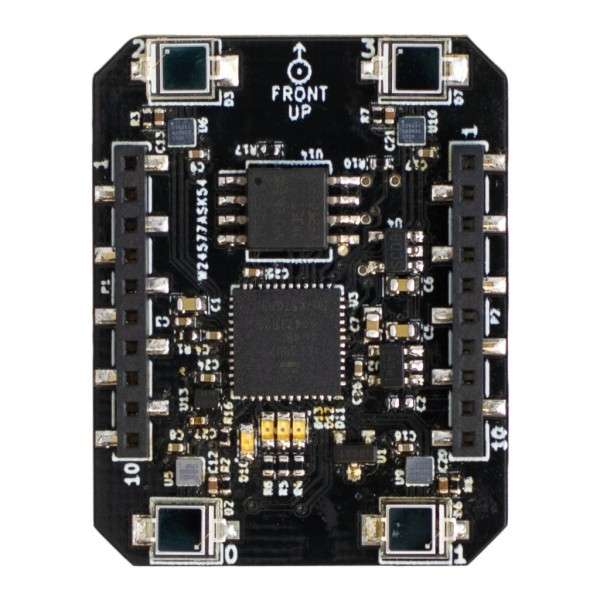

I'm assuming the numbers on the edges correspond to the sensor IDs during operation.

The pre-set yaw angle to sensor order mapping is as follows (this assumes the BS is above the CF pointing down at it)

In [4]:
import math

# Numbers passed to math.radians are angles
directions = {
    hash_sensor_order([2, 0, 1, 3]): math.radians(0),
    hash_sensor_order([2, 0, 3, 1]): math.radians(25),
    hash_sensor_order([2, 3, 0, 1]): math.radians(65),
    hash_sensor_order([3, 2, 0, 1]): math.radians(90),
    hash_sensor_order([3, 2, 1, 0]): math.radians(115),
    hash_sensor_order([3, 1, 2, 0]): math.radians(155),
    hash_sensor_order([1, 3, 2, 0]): math.radians(180),
    hash_sensor_order([1, 3, 0, 2]): math.radians(205),
    hash_sensor_order([1, 0, 3, 2]): math.radians(245),
    hash_sensor_order([0, 1, 3, 2]): math.radians(270),
    hash_sensor_order([0, 1, 2, 3]): math.radians(295),
    hash_sensor_order([0, 2, 1, 3]): math.radians(335),
}

If you imagine a CF with a lighthouse deck on top, with sensors numbered as in the picture above, the degree values in this map make sense for the different sensor orders (to intuit this better I labelled the corners of a piece of paper with the sensor numbers and rotated it around, imagining I was a base station doing horizontal scans).

In order to have both an up-sensor and down-sensor BS be in "view", the CF needs to be turned on its side:

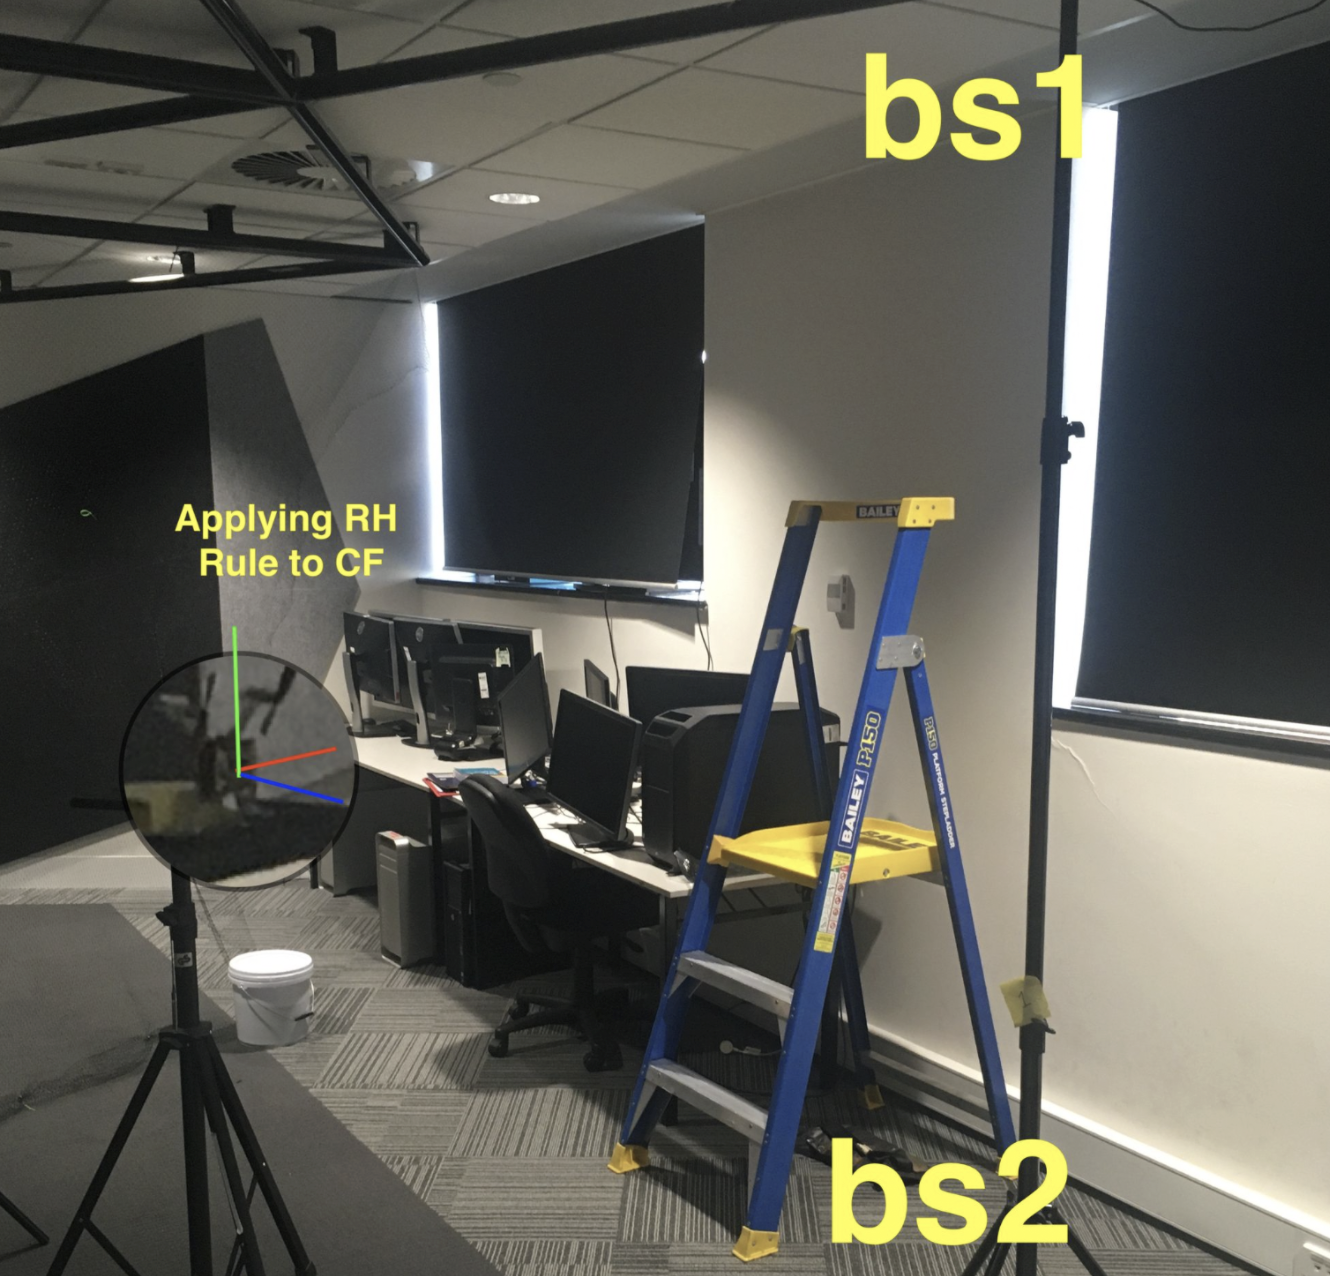

In this configuration, we instead want to find the "pitch" of the CF, rather than the yaw, which is the equivalent angle with the CF flipped on its side. To do this, we need to do things a little differently, as no matter what pitch angle the CF is at, sensors (0 and 2) and (1 and 3) will be always be hit at the same time by the vertical sweep, and sensors (2 and 3) and (0 and 1) will always be hit at the same time by the horizontal sweep. 

There's probably a few ways to to do this. Here's my proposal (pitch, if you will (you will))

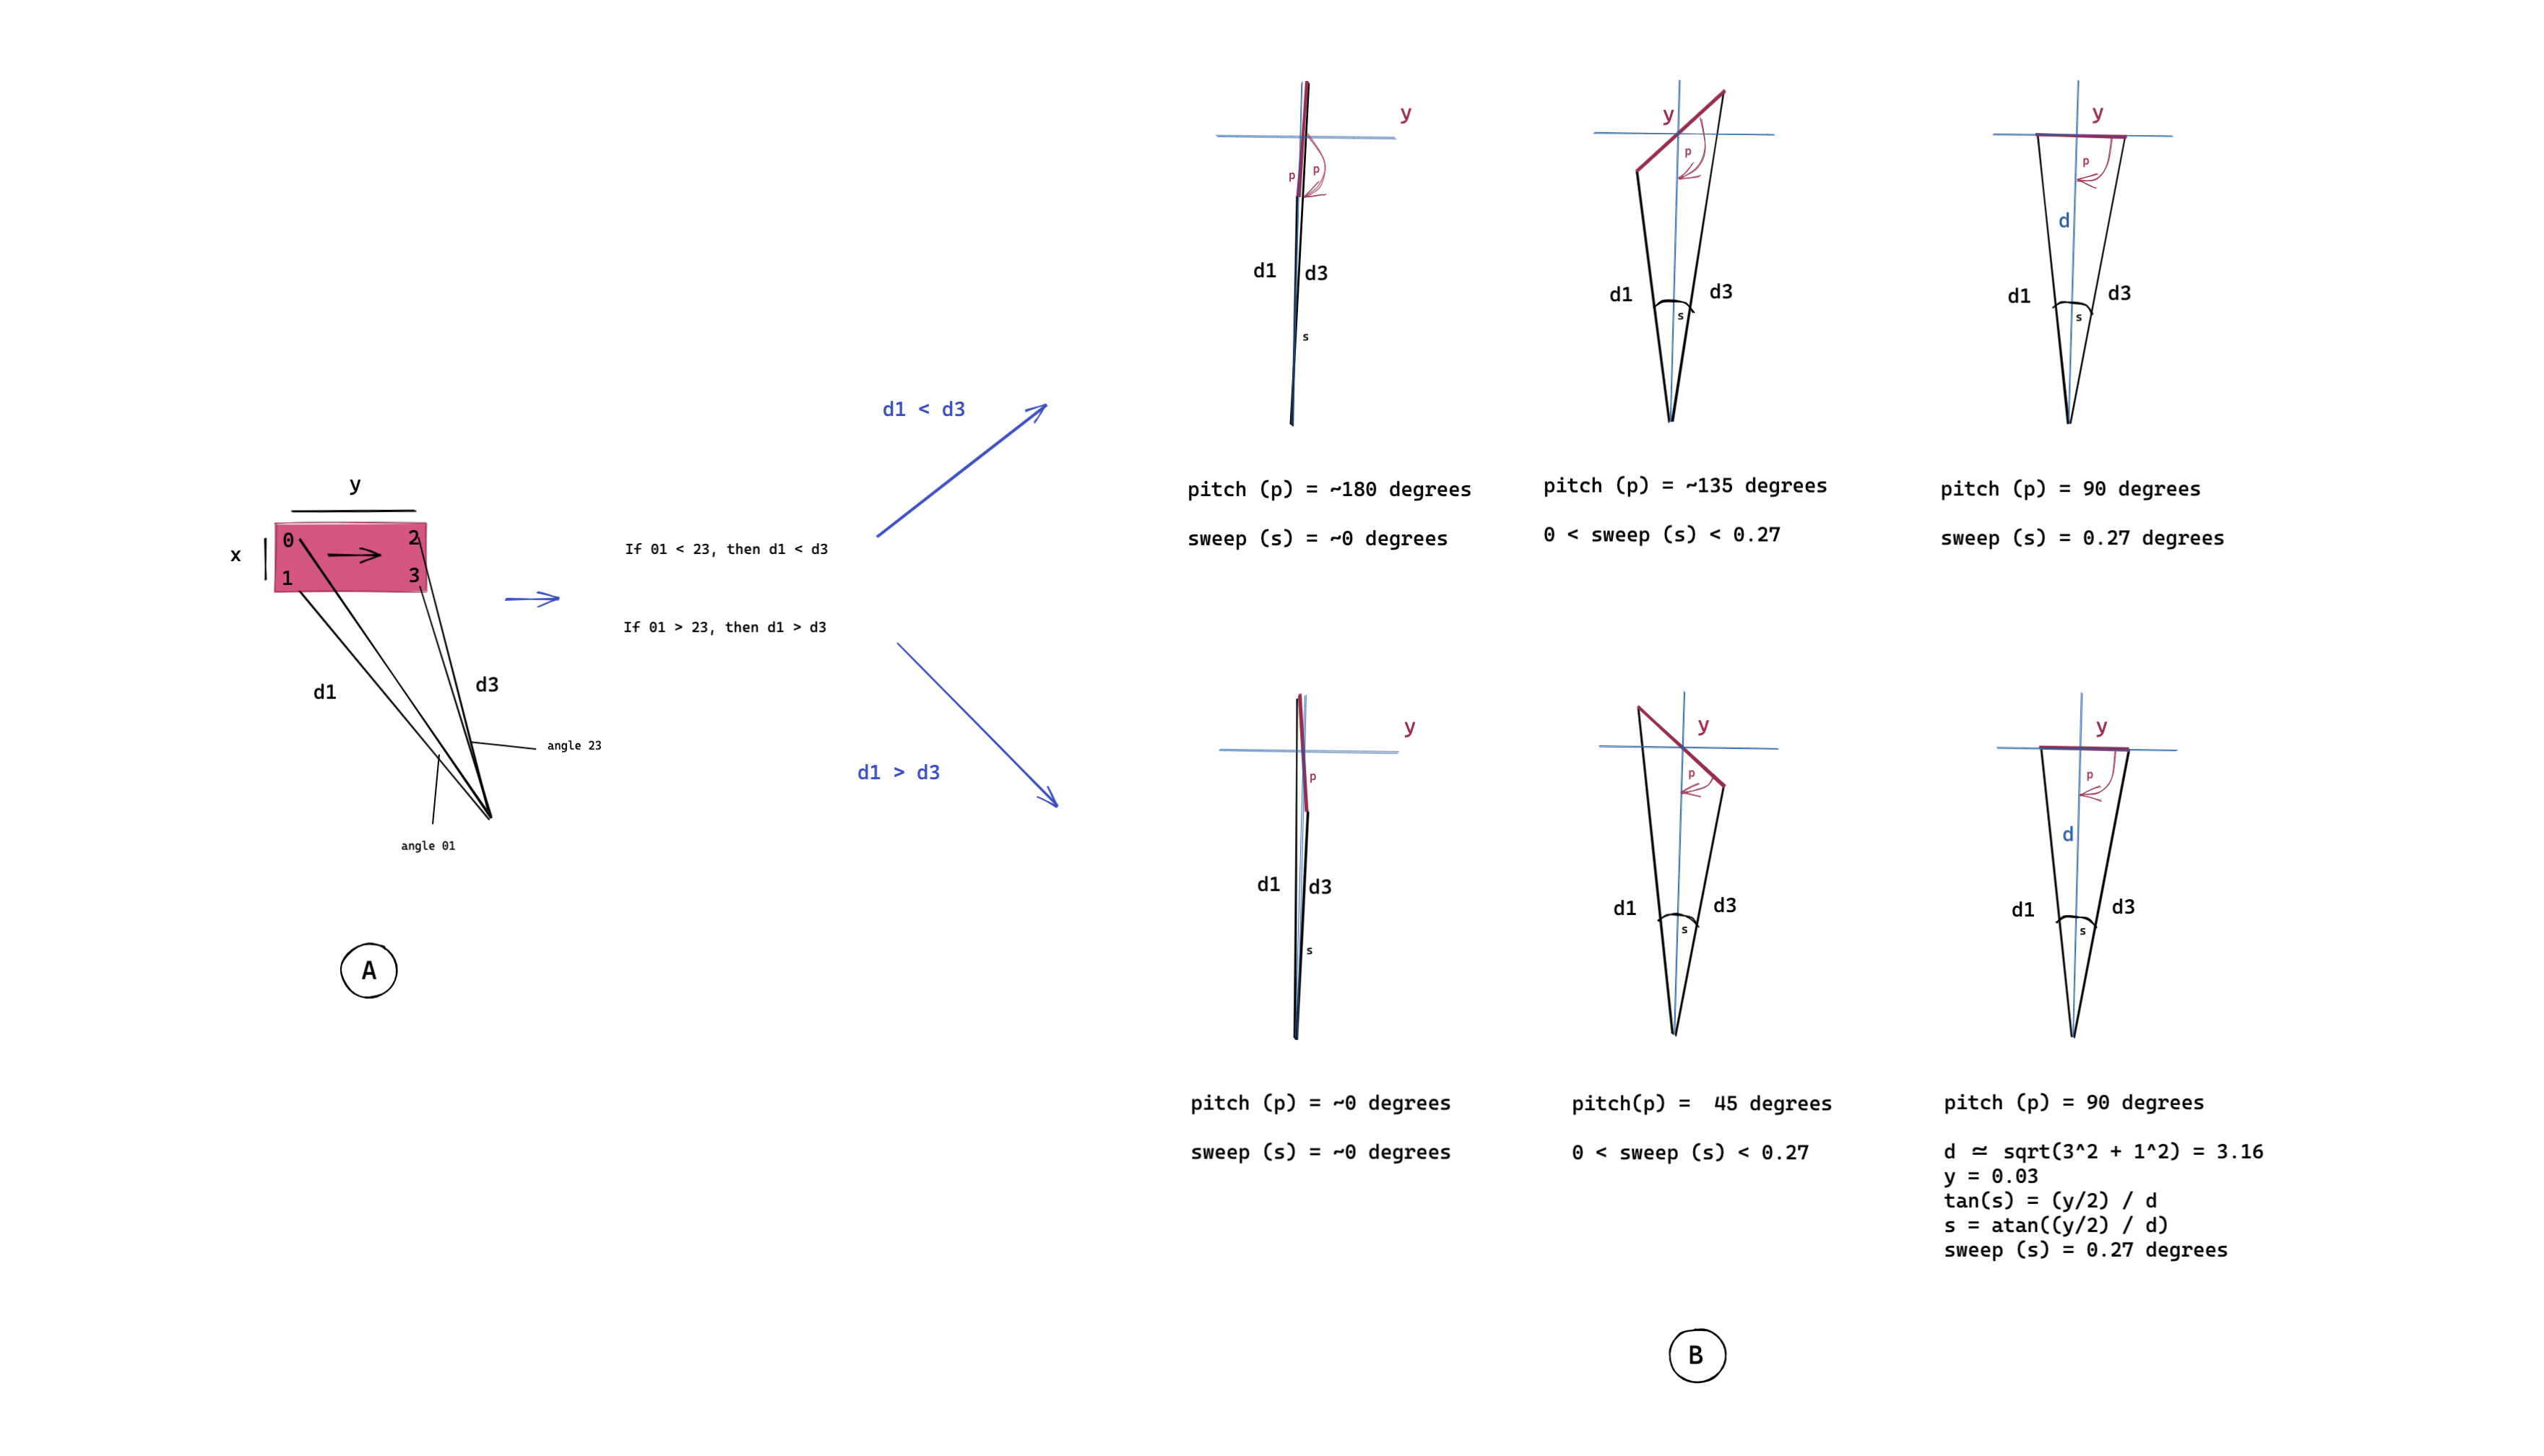

Note that this assumes the CF is flipped on its side with the Y-axis facing up.


- (A) `x` and `y` are known, as physical constants of the CF lighthouse deck, `d1` is the distance from the BS to sensor 1, `d3` is the distance from the BS to sensors 2 and 3. As we know the angle difference between sensors 0 and 1 (and 2 and 3) from our vertical sweep data, we can therefore calculate which of `d1` or `d3` is bigger, which gives us a 90 degree range that our 
- (B) Now, if we assume that the distance to the centroid of the CF from the BS is about 3.16m (3m along the ground, 1m vertically), we can calculate what the sweep angle should be for a 90 degree pitch. We also know that the pitch angle angle should be either 180 or 0 for a 0 degree pitch. We can use this knowledge to infer a mapping between pitch and sweep angle (where at run-time we'll be solving for pitch based on sweep angle)

Let's modify the code to do this:

In [30]:
import math

# Numbers passed to math.radians are angles

# Turning right is positive yaw
yaw_directions = {
    hash_sensor_order([2, 0, 1, 3]): math.radians(0),
    hash_sensor_order([2, 0, 3, 1]): math.radians(25),
    hash_sensor_order([2, 3, 0, 1]): math.radians(65),
    hash_sensor_order([3, 2, 0, 1]): math.radians(90),
    hash_sensor_order([3, 2, 1, 0]): math.radians(115),
    hash_sensor_order([3, 1, 2, 0]): math.radians(155),
    hash_sensor_order([1, 3, 2, 0]): math.radians(180),
    hash_sensor_order([1, 3, 0, 2]): math.radians(205),
    hash_sensor_order([1, 0, 3, 2]): math.radians(245),
    hash_sensor_order([0, 1, 3, 2]): math.radians(270),
    hash_sensor_order([0, 1, 2, 3]): math.radians(295),
    hash_sensor_order([0, 2, 1, 3]): math.radians(335),
}

def bs_is_on_ceiling(bs_id):
    if bs_id == 0:
        return True
    if bs_id == 1:
        return True
    if bs_id == 2:
        return False


def find_initial_yaw_or_pitch_guess(bs_vectors, bs_id, sideways):
   
    if sideways:
        
        # Use sweep angles
        
        # Assumes distance along floor between CF and BS is 3, and relative height is 1 
        # (straight dist 3.16)
        
        # Vertical angles
        sweep_angle_01 = bs_vectors[1].lh_v1_vert_angle - bs_vectors[0].lh_v1_vert_angle
        sweep_angle_23 = bs_vectors[3].lh_v1_vert_angle - bs_vectors[2].lh_v1_vert_angle
        
        # Horizontal angles
        sweep_angle_31 = bs_vectors[1].lh_v1_horiz_angle - bs_vectors[3].lh_v1_horiz_angle
                
        # TODO I may need to make the returned pitch angles negative
        
        if sweep_angle_01 < sweep_angle_23:
            
            assert sweep_angle_31 > 0
            
            if math.degrees(sweep_angle_31) < 0.05:
            
                return math.radians(0)
                
            if math.degrees(sweep_angle_31) < 0.15:
            
                return math.radians(25)
            
            elif math.degrees(sweep_angle_31) < 0.25:
            
                return math.radians(65)
                
            else:
            
                return math.radians(90)
                                   
        else:
            
            assert sweep_angle_31 > 0
            
            if math.degrees(sweep_angle_31) < 0.05:
            
                return math.radians(180)
                
            if math.degrees(sweep_angle_31) < 0.15:
            
                return math.radians(155)
            
            elif math.degrees(sweep_angle_31) < 0.25:
            
                return math.radians(115)
                
            else:
            
                return math.radians(90)
                
        
    else:
        
        # Use horizontal sweeps and pre-set yaw map
        
        sweeps_x = {
            0: bs_vectors[0].lh_v1_horiz_angle,
            1: bs_vectors[1].lh_v1_horiz_angle,
            2: bs_vectors[2].lh_v1_horiz_angle,
            3: bs_vectors[3].lh_v1_horiz_angle
        }

        ordered_map_x = {k: v for k, v in
                         sorted(sweeps_x.items(), key=lambda item: item[1])}
        sensor_order_x = list(ordered_map_x.keys())
        
        # The base station is roughly in this yaw direction, in CF (world) coordinates
        return yaw_directions[hash_sensor_order(sensor_order_x)]
    

Checking

In [31]:
import pickle

upways_sensor_data_path = "sensor_data_1614655937013395.pickle"
sideways_sensor_data_path = "sensor_data_1614655377286432.pickle"

sideways_sensor_data = pickle.load(open(sideways_sensor_data_path, "rb"))
upways_sensor_data = pickle.load(open(upways_sensor_data_path, "rb"))

print("Upways:")

for id in sorted(upways_sensor_data.keys()):
    average_data = upways_sensor_data[id]
    sensor_data = average_data[1]
    print(f"Base station {id} yaw estimate: {math.degrees(find_initial_yaw_or_pitch_guess(sensor_data, id, sideways=False))} degrees")

print("Sideways:")
    
for id in sorted(sideways_sensor_data.keys()):
    average_data = sideways_sensor_data[id]
    sensor_data = average_data[1]
    print(f"Base station {id} pitch estimate: {math.degrees(find_initial_yaw_or_pitch_guess(sensor_data, id, sideways=True))} degrees")



Upways:
Base station 0 yaw estimate: 295.0 degrees
Base station 1 yaw estimate: 115.0 degrees
Sideways:
Base station 1 pitch estimate: 90.0 degrees
Base station 2 pitch estimate: 90.0 degrees


# (2) Update `_convert_yaw_to_open_cv` 

Next, we look at `_convert_yaw_to_open_cv`. This function takes the yaw guess (which is from the perspective of the CF), and uses it to make an initial guess of the pose of the CF in BS coordinates (camera coordinates this time). I expect there's some assumptions baked into this code about the relative positions of the CF and BS, which we'll need to adjust. Unfortunately, there's not much in the code to tell us what it's doing, so I'll first run through and understand it properly. 

## A run-through of the original version

Here's the original version:

In [50]:
# Calculate rotation matrix

import math
import numpy as np
import cv2 as cv

def convert_yaw_to_open_cv(yaw):
    
    # Base station height
    bs_h = 2.0
    # Distance to base station along the floor
    bs_fd = 3.0
    # Distance to base station
    bs_dist = math.sqrt(bs_h ** 2 + bs_fd ** 2)
    elevation = math.atan2(bs_h, bs_fd)

    # Initial position of the CF in camera coordinate system, open cv style
    tvec_start = np.array([0, 0, bs_dist])

    # Calculate rotation matrix
    d_c = math.cos(-yaw + math.pi)
    d_s = math.sin(-yaw + math.pi)
    R_rot_y = np.array([
        [d_c, 0.0, d_s],
        [0.0, 1.0, 0.0],
        [-d_s, 0.0, d_c],
    ])

    e_c = math.cos(elevation)
    e_s = math.sin(elevation)
    R_rot_x = np.array([
        [1.0, 0.0, 0.0],
        [0.0, e_c, -e_s],
        [0.0, e_s, e_c],
    ])

    R = np.dot(R_rot_x, R_rot_y)
    rvec_start, _ = cv.Rodrigues(R)

    return rvec_start, tvec_start, R, R_rot_x, R_rot_y  # Note I updated this for debugging

The "camera coordinate" system appears to be as follows, based on [this open cv documentation](https://docs.opencv.org/master/d9/d0c/group__calib3d.html) (ctrl-f "detailed description"):

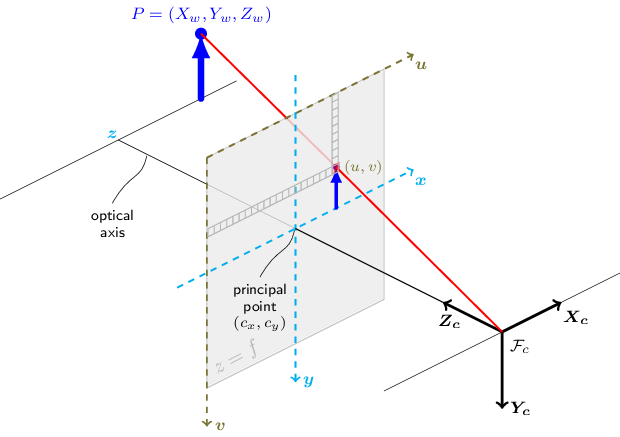

Note that the Y axis is now pointing down in the world reference system (so negative Z in the normal BS reference system), and the Z axis is pointing directly out the front of the "lens" (so positive X in the normal BS reference system)


Given this, taking the `convert_yaw_to_open_cv` step by step:

1. We estimate the distance `bs_dist` from the CF to the BS based on pre-canned values for base station height and distance along floor (2 and 3 respectively)
2. We guess that the position of the CF in the BS camera coordinate system (BSCC) is directly in front of it in the Z direction, i.e. the middle of the camera lens is pointing directly at it.
3. We now look at the rotation of the CF in the BSCC. We first look at its probable rotation about the BSCC Y-axis,which is going to be based on our yaw guess. This is `R_rot_y`:

    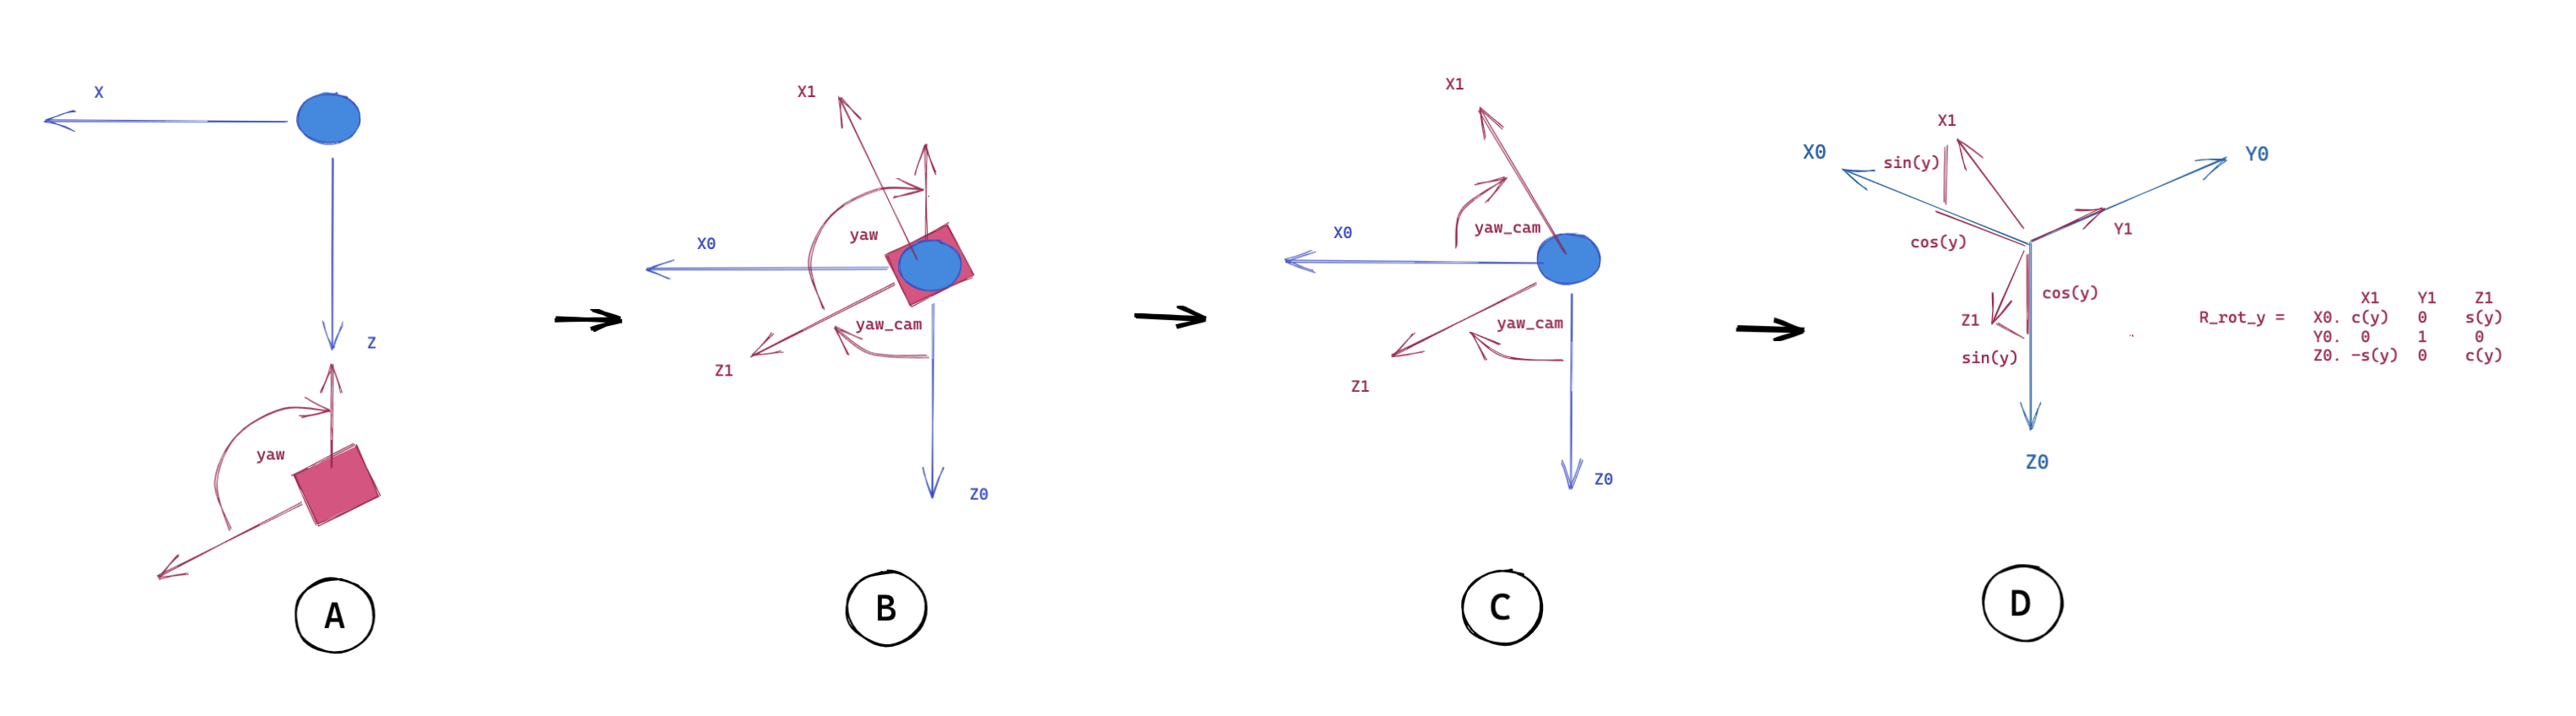

    (the pink deck is the CF and the blue orb is the BS). Steps in the diagram above:

    - (A) Assume the yaw is occurring in the BSCC X-Z plane, which is a valid assumption with a shallow enough elevation angle. Given we've defined earlier that the Z axis is pointing straight at the CF, we can also reference the yaw angle against this axis.
    - (B) The yaw angle we guessed earlier needs to be mirrored to translate it into the BSCC reference frame, as the Z-axis is pointing the other direction. The mirrored yaw angle is `yaw_cam`, which is equivalent to the supplement of the `yaw` angle, which is found in the code using `-yaw + math.pi`
    - (C) We now have the basis for finding a rotation matrix describing the CF's orientation in the BSCC reference frame about the BSCC Y-axis (note that this is just one component of the complete rotation matrix).
    - (D) We can now calculate `R_rot_y`. You can work this out yourself by calculating each element of the matrix as the projection of the row onto the column, i.e. the top left element is the projection of X1 onto X0. There's a good explanation of this process here: https://www.youtube.com/watch?v=lVjFhNv2N8o


4. We then look at its probable rotation about the BSCC X-axis, which is going to correlate to the elevation of the CF. This is `R_rot_x`:
    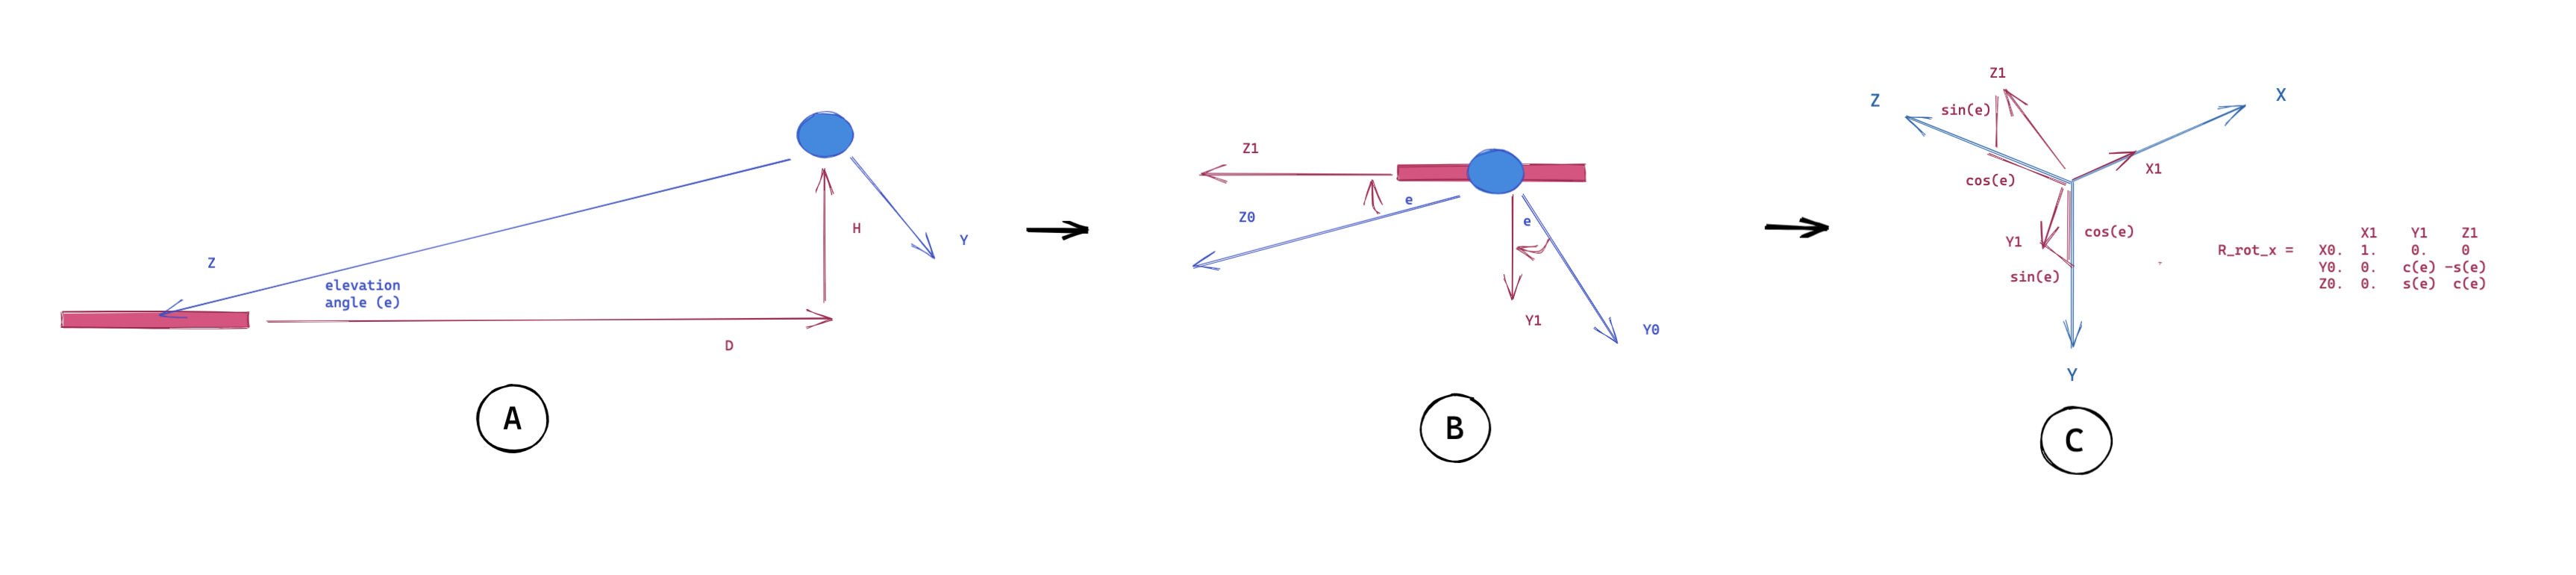
    

Steps in the diagram above:

- (A) First calculate the elevation angle of the BS with respect to the CF. To do this, we use the same pre-canned values as in (1) for height (H) and distance along floor (D), taking advantage of the assumption that the CF is directly straight ahead in the BSCC Z axis.
- (B) This gives us the rotation of the CF about the BSCC X-axis
- (C) We then calculate `R_rot_x`, using a similar procedure as for `R_rot_y`


5. We don't look at its rotation about the BSCC Z-axis, presumably because we're assuming the elevation angle is sufficiently shallow. 
6. We then take the dot product of the `R_rot_x` and `R_rot_y` (`np.dot(R_rot_x, R_rot_y)`). The result of this is the rotation matrix you'd get if you first performed the `R_rot_y` rotation, then the `R_rot_x` rotation.
7. Lastly, we convert the rotation matrix that comes out of (6) into a rotation vector using `cv.Rodrigues(R)`


In [51]:
# Examples finding yaw_cam (supplement of yaw)

import math

r = lambda deg: math.radians(deg)

print(math.degrees(-r(10) + math.pi))
print(math.degrees(-r(90) + math.pi))
print(math.degrees(-r(180) + math.pi))
print(math.degrees(-r(270) + math.pi))

170.0
90.0
0.0
-90.0


Checking the results this gives us:

In [52]:
import pickle

upways_sensor_data_path = "sensor_data_1614655937013395.pickle"
sideways_sensor_data_path = "sensor_data_1614655377286432.pickle"

sideways_sensor_data = pickle.load(open(sideways_sensor_data_path, "rb"))
upways_sensor_data = pickle.load(open(upways_sensor_data_path, "rb"))

print("Upways:")

results = {}

for bs_id in sorted(upways_sensor_data.keys()):
    average_data = upways_sensor_data[bs_id]
    sensor_data = average_data[1]
    yaw_rad = find_initial_yaw_or_pitch_guess(sensor_data, bs_id, sideways=False)
    rvec, tvec, R, R_x, R_y = convert_yaw_to_open_cv(yaw_rad)
    print(f"Base station {bs_id} yaw estimate: {math.degrees(yaw_rad)} degrees")
    results[bs_id] = [tvec, R, R_x, R_y]


Upways:
Base station 0 yaw estimate: 295.0 degrees
Base station 1 yaw estimate: 115.0 degrees


In [53]:
show_pose(results[0][0], results[0][3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
show_pose(results[1][0], results[1][1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Updates to the code for a sideways world

Here's the same list of operations, but adjusted for the CF being sideways, and there being two possible orientations of the BS - floor and ceiling

1. We estimate the distance `bs_dist` from the CF to the BS based on pre-canned values for base station height and distance along floor (1 and 3 respectively for the ceiling BS, -1 and 3 respectively for the floor BS)
2. We guess that the position of the CF in the BS camera coordinate system (BSCC) is directly in front of it in the Z direction, i.e. the middle of the camera lens is pointing directly at it.
3. We now look at the rotation of the CF in the BSCC. We first look at its probable rotation about the BSCC Y-axis,which is going to be based on our pitch guess. This is `R_rot_y`, and is worked out basically the same as before:

    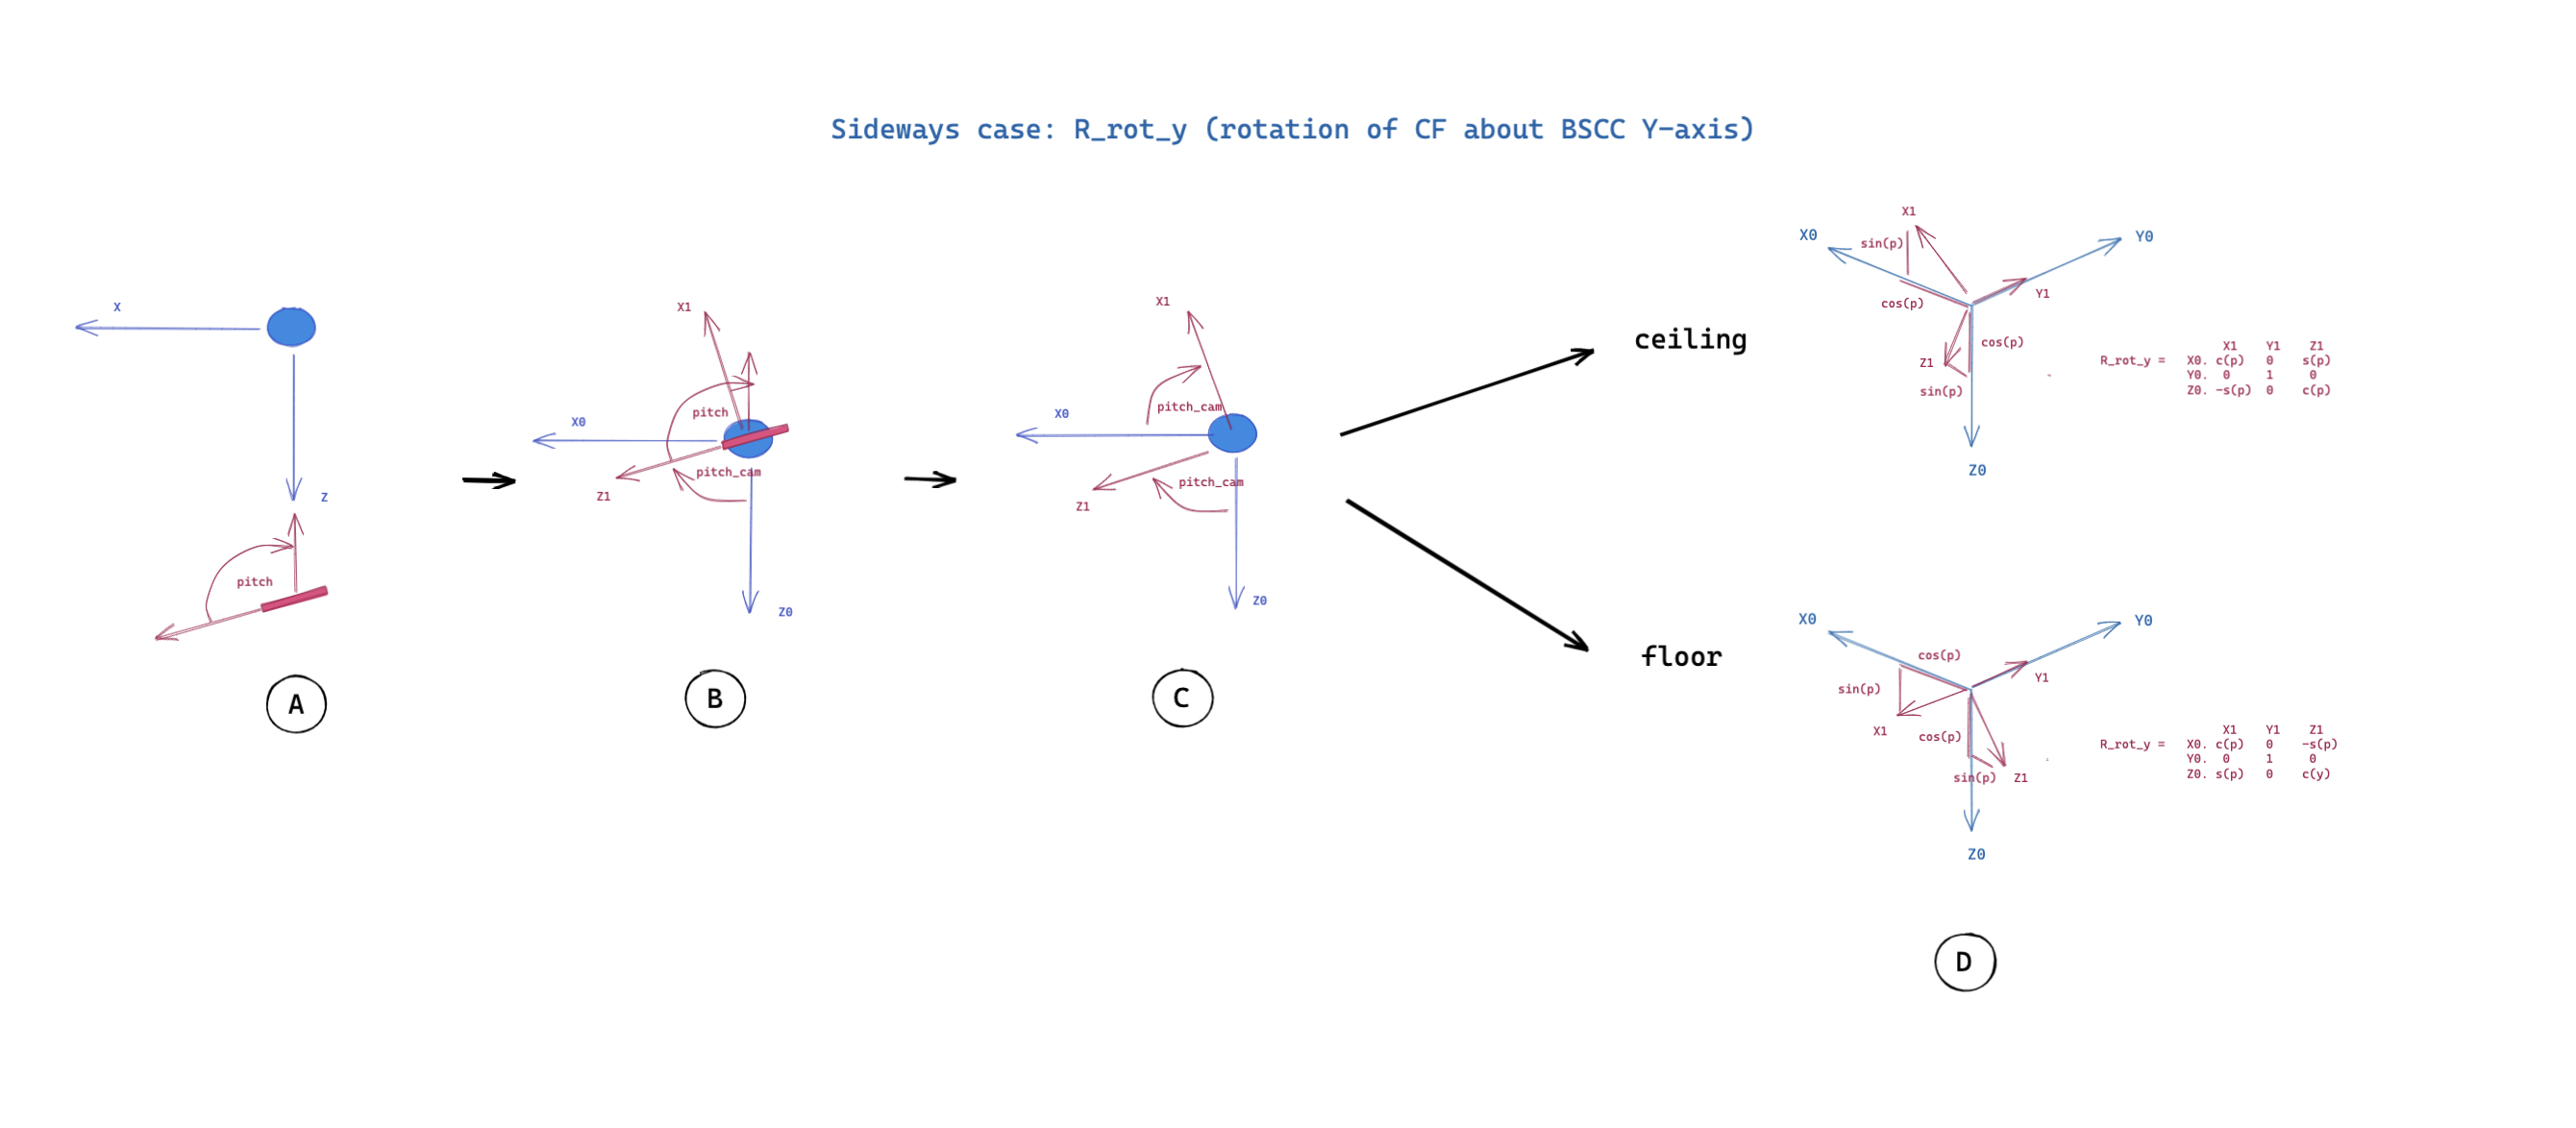

    (the pink deck is the CF and the blue orb is the BS). Steps in the diagram above:

    - (A) Assume the pitch is occurring in the BSCC X-Z plane, which is a valid assumption with a shallow enough elevation angle. Given we've defined earlier that the Z axis is pointing straight at the CF, we can also reference the pitch angle against this axis. 
    - (B) The pitch angle we guessed earlier needs to be mirrored to translate it into the BSCC reference frame, as the Z-axis is pointing the other direction. The mirrored pitch angle is `pitch_cam`, which is equivalent to the supplement of the `pitch` angle, which is found in the code using `-pitch + math.pi`
    - (C)/(D) We now have the basis for finding a rotation matrix describing the CF's orientation in the BSCC reference frame about the BSCC Y-axis (note that this is just one component of the complete rotation matrix). Note that we have one case for the floor case, and one for the ceiling case.


4. We then look at its probable rotation about the BSCC X-axis, which is going to correlate to the elevation of the CF. This is `R_rot_x`:
    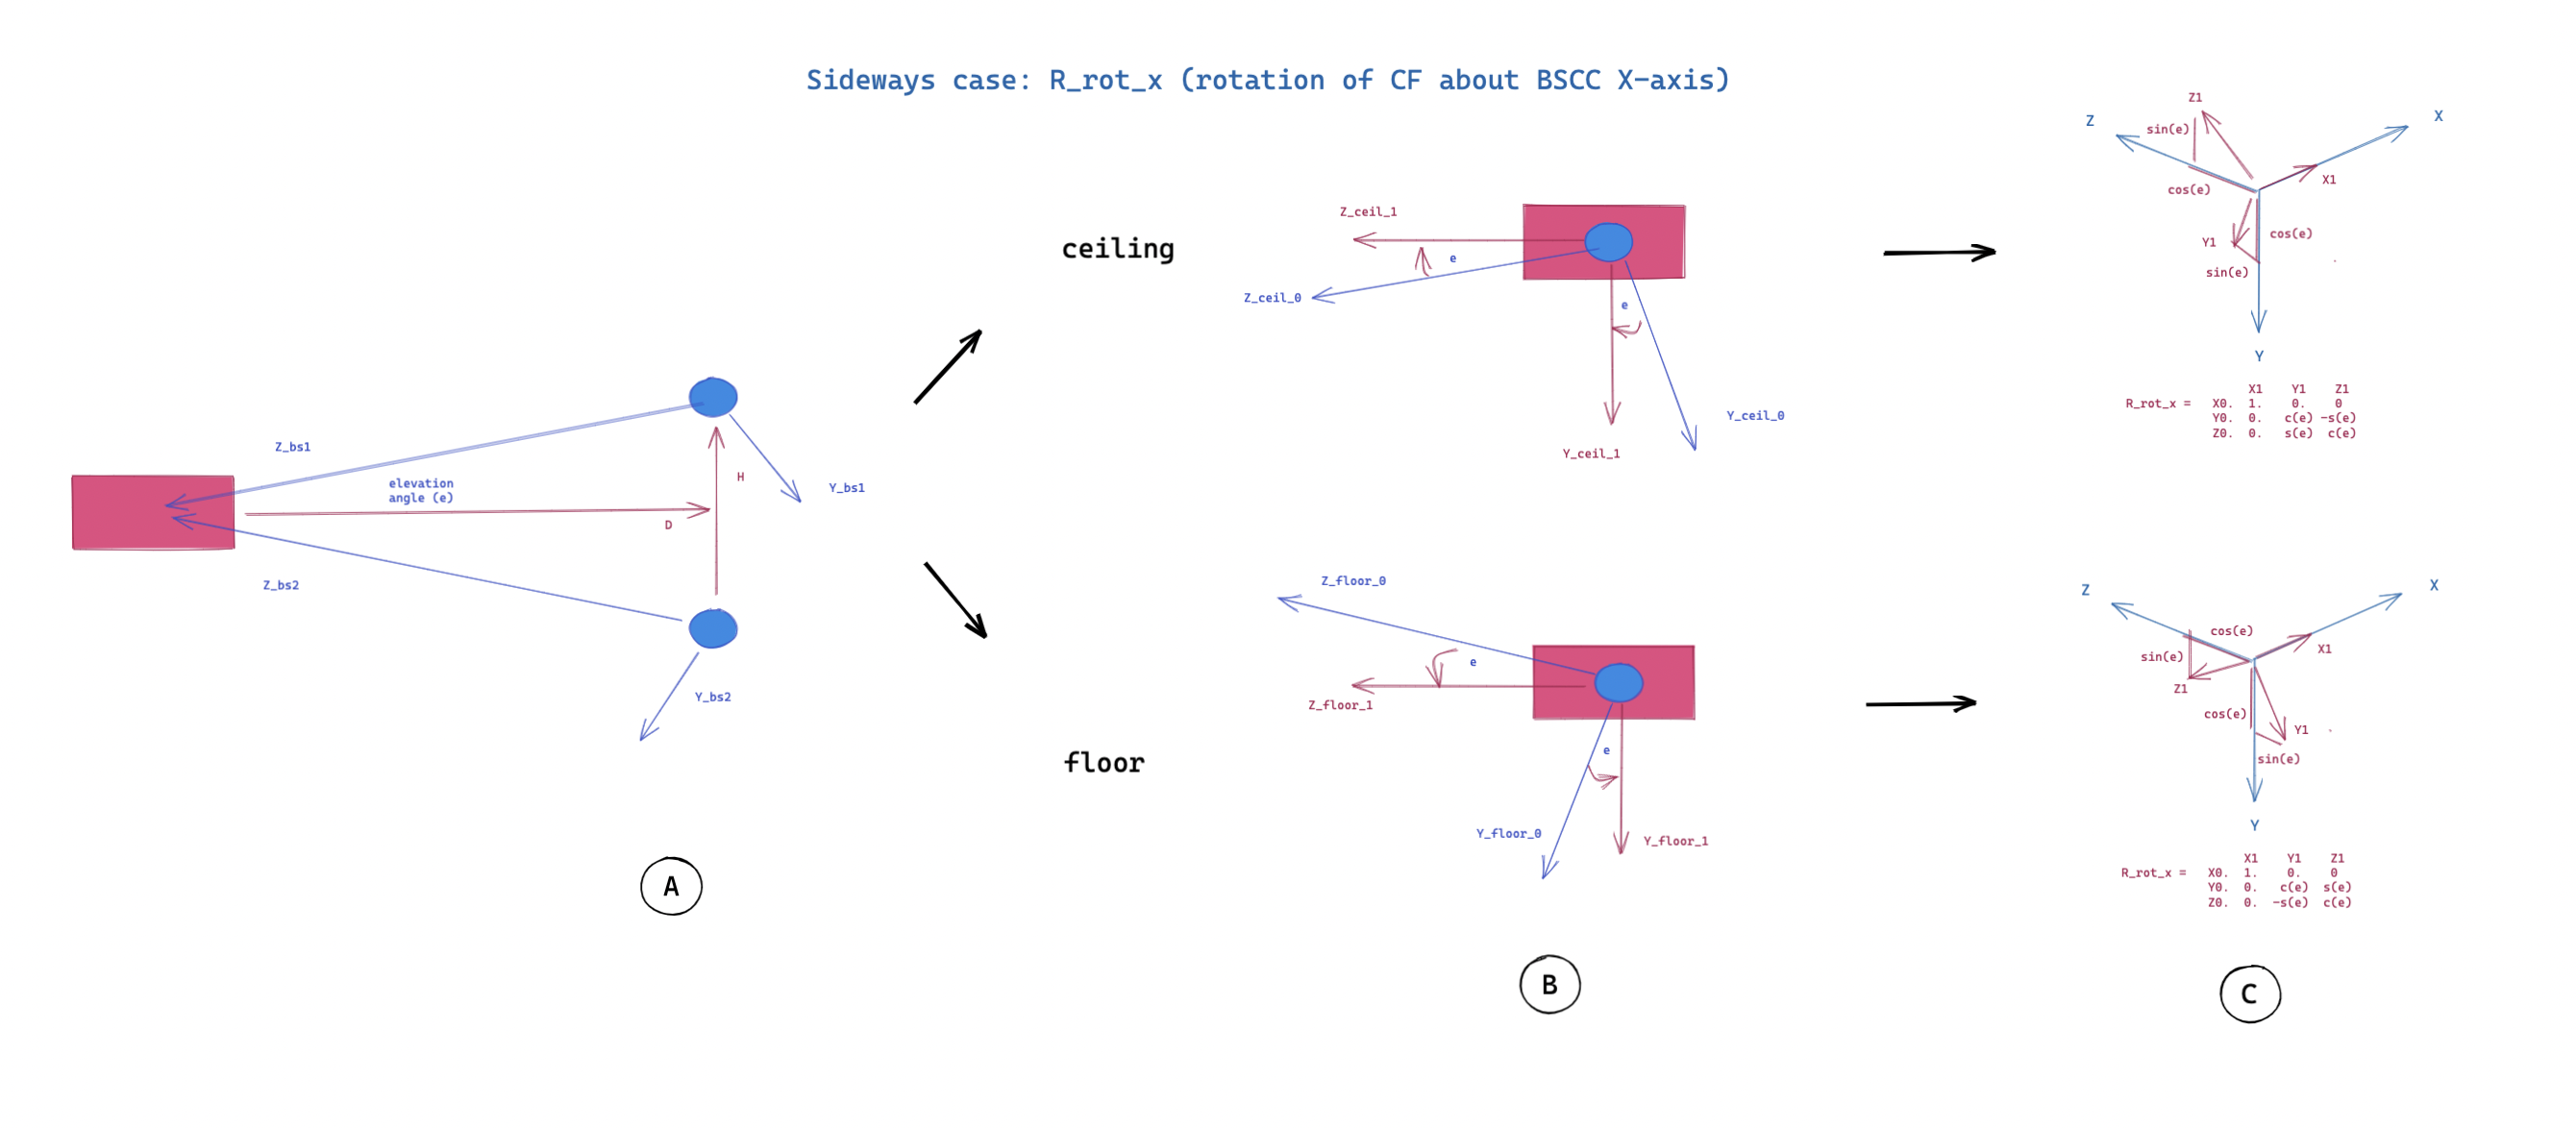
    

Steps in the diagram above:

- (A) First calculate the elevation angle of the BS with respect to the CF. To do this, we use the same pre-canned values as in (1) for height (H) and distance along floor (D), taking advantage of the assumption that the CF is directly straight ahead in the BSCC Z axis. Note that we have one case for the floor case, and one for the ceiling case.
- (B) This gives us the rotation of the CF about the BSCC X-axis
- (C) We then calculate `R_rot_x`, using a similar procedure as for `R_rot_y`


5. We don't look at its rotation about the BSCC Z-axis, presumably because we're assuming the elevation angle is sufficiently shallow. 
6. We then take the dot product of the `R_rot_x` and `R_rot_y` (`np.dot(R_rot_x, R_rot_y)`). The result of this is the rotation matrix you'd get if you first performed the `R_rot_y` rotation, then the `R_rot_x` rotation.
7. Lastly, we convert the rotation matrix that comes out of (6) into a rotation vector using `cv.Rodrigues(R)`


In [55]:
# Calculate rotation matrix

import math
import numpy as np
import cv2 as cv


def bs_is_on_ceiling(bs_id):
    if bs_id == 0:
        return True
    if bs_id == 1:
        return True
    if bs_id == 2:
        return False
    

def convert_yaw_or_pitch_to_open_cv(yaw_or_pitch, sideways, bs_id):
    
    if sideways:
        
        # Base station height
        # If BS on floor, is in the negative directionn
        bs_h = 1.0 if bs_is_on_ceiling(bs_id) else -1.0

        # Distance to base station along the floor
        bs_fd = 3.0
        
        # Distance to base station
        bs_dist = math.sqrt(bs_h ** 2 + bs_fd ** 2)
        
        # Elevation angle of BS with respect to CF - will be
        # negative if BS is on floor
        elevation = math.atan2(bs_h, bs_fd)

        # Initial position of the CF in camera coordinate system, open cv style
        tvec_start = np.array([0, 0, bs_dist])

        # Calculate rotation matrix
        
        # For rotation about y, we still mirror the yaw angle
        d_c = math.cos(-yaw_or_pitch + math.pi)
        d_s = math.sin(-yaw_or_pitch + math.pi)
        
        if bs_is_on_ceiling(bs_id):
            R_rot_y = np.array([
                [d_c, 0.0, d_s],
                [0.0, 1.0, 0.0],
                [-d_s, 0.0, d_c],
            ])
        else:
            R_rot_y = np.array([
                [d_c, 0.0, -d_s],
                [0.0, 1.0, 0.0],
                [d_s, 0.0, d_c],
            ])
            

        e_c = math.cos(elevation)
        e_s = math.sin(elevation)
        
        if bs_is_on_ceiling:
            R_rot_x = np.array([
                [1.0, 0.0, 0.0],
                [0.0, e_c, -e_s],
                [0.0, e_s, e_c],
            ])
        else:
            R_rot_x = np.array([
                [1.0, 0.0, 0.0],
                [0.0, e_c, e_s],
                [0.0, -e_s, e_c],
            ])
            

        R = np.dot(R_rot_x, R_rot_y)
        rvec_start, _ = cv.Rodrigues(R)
    
    else:
        
        # Base station height
        bs_h = 2.0

        # Distance to base station along the floor
        bs_fd = 3.0
        
        # Distance to base station
        bs_dist = math.sqrt(bs_h ** 2 + bs_fd ** 2)
        elevation = math.atan2(bs_h, bs_fd)

        # Initial position of the CF in camera coordinate system, open cv style
        tvec_start = np.array([0, 0, bs_dist])

        # Calculate rotation matrix
        d_c = math.cos(-yaw_or_pitch + math.pi)
        d_s = math.sin(-yaw_or_pitch + math.pi)
        R_rot_y = np.array([
            [d_c, 0.0, d_s],
            [0.0, 1.0, 0.0],
            [-d_s, 0.0, d_c],
        ])

        e_c = math.cos(elevation)
        e_s = math.sin(elevation)
        R_rot_x = np.array([
            [1.0, 0.0, 0.0],
            [0.0, e_c, -e_s],
            [0.0, e_s, e_c],
        ])

        R = np.dot(R_rot_x, R_rot_y)
        rvec_start, _ = cv.Rodrigues(R)

    return rvec_start, tvec_start, R, R_rot_x, R_rot_y  # Note I updated this for debugging

In [56]:
import pickle

upways_sensor_data_path = "sensor_data_1614655937013395.pickle"
sideways_sensor_data_path = "sensor_data_1614655377286432.pickle"

sideways_sensor_data = pickle.load(open(sideways_sensor_data_path, "rb"))
upways_sensor_data = pickle.load(open(upways_sensor_data_path, "rb"))

print("Sideways:")

results = {}

for bs_id in sorted(sideways_sensor_data.keys()):
    average_data = sideways_sensor_data[bs_id]
    sensor_data = average_data[1]
    angle_rad = find_initial_yaw_or_pitch_guess(sensor_data, bs_id, sideways=True)
    rvec, tvec, R, R_x, R_y = convert_yaw_or_pitch_to_open_cv(angle_rad, sideways=True, bs_id=bs_id)
    print(f"Base station {bs_id} pitch estimate: {math.degrees(angle_rad)} degrees")
    results[bs_id] = [tvec, R, R_x, R_y]

Sideways:
Base station 1 pitch estimate: 90.0 degrees
Base station 2 pitch estimate: 90.0 degrees


In [60]:
show_pose(results[1][0], results[1][3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [61]:
show_pose(results[2][0], results[2][3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [57]:
# Examples finding yaw_cam (supplement of yaw)

import math

r = lambda deg: math.radians(deg)

print(math.degrees(-r(10) + math.pi))
print(math.degrees(-r(90) + math.pi))
print(math.degrees(-r(180) + math.pi))
print(math.degrees(-r(270) + math.pi))

170.0
90.0
0.0
-90.0


# (3) Update `_estimate_pose_by_pnp` 

This takes the sensor data and the position and rotation guesses, then uses it to estimate the pose.

In [58]:
def _estimate_pose_by_pnp(self, bs_vectors, rvec_start, tvec_start):
    
    # Sensors as seen by the "camera"
    lighthouse_image_projection = np.float32(
        [
            [-math.tan(bs_vectors[0].lh_v1_horiz_angle), -math.tan(bs_vectors[0].lh_v1_vert_angle)],
            [-math.tan(bs_vectors[1].lh_v1_horiz_angle), -math.tan(bs_vectors[1].lh_v1_vert_angle)],
            [-math.tan(bs_vectors[2].lh_v1_horiz_angle), -math.tan(bs_vectors[2].lh_v1_vert_angle)],
            [-math.tan(bs_vectors[3].lh_v1_horiz_angle), -math.tan(bs_vectors[3].lh_v1_vert_angle)]
        ])

    _ret, rvec_est, tvec_est = cv.solvePnP(
        self._lighthouse_3d,
        lighthouse_image_projection,
        self._K,
        self._dist_coef,
        flags=cv.SOLVEPNP_ITERATIVE,
        rvec=rvec_start,
        tvec=tvec_start,
        useExtrinsicGuess=True)

    if not _ret:
        raise Exception('No solution found')

    Rw_ocv, Tw_ocv = self._cam_to_world(rvec_est, tvec_est)
    return Rw_ocv, Tw_ocv

Going through this code:

`cv.solvePnP` finds an object's pose based on the 3D and 2D point correspondences. In this case, we have the 3D points of our position and rotation vector guesses (`tvec_start` and `rvec_start` respectively), and the 2D points carved out vertical and horizontal angles read by our base station (found in `bs_vectors`). 

To do this, we first need to map out our 2D points: `lighthouse_image_projection`. We then run `solvePnP` with this plus our position and rotation guesses.


There's a few class attributes being used in `cv.solvePnP`, which are as follows:
- `self._lighthouse_3d`: an array of object points in the object coordinate space (our CF or world reference system). This is what we use:
        ```
        # Sensor positions in world coordinates, open cv style
        self._lighthouse_3d = np.float32(
            [
                [-sensor_distance_width / 2, 0, -sensor_distance_length / 2],
                [sensor_distance_width / 2, 0, -sensor_distance_length / 2],
                [-sensor_distance_width / 2, 0, sensor_distance_length / 2],
                [sensor_distance_width / 2, 0, sensor_distance_length / 2]
            ]
        )
        ```
- `self._K`: Input camera intrinsic matrix ??
        ```
        self._K = np.float64(
            [
                [1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0],
                [0.0, 0.0, 1.0]
        ])

        ```
- `self._dist_coef`: distortion coefficients
        ```
        self._dist_coef = np.zeros(4)
        ```


On initial inspection I don't think any of this needs to change - I'll have a more in depth look tomorrow though.

# (4) Update `_opencv_to_cf` 

This function takes the pose in the open CV camera coordinate system, and translates it into the CF reference frame.

In [ ]:
def _opencv_to_cf(self, R_cv, t_cv):
    R_opencv_to_cf = np.array([
        [0.0, 0.0, 1.0],
        [-1.0, 0.0, 0.0],
        [0.0, -1.0, 0.0],
    ])

    R_cf_to_opencv = np.array([
        [0.0, -1.0, 0.0],
        [0.0, 0.0, -1.0],
        [1.0, 0.0, 0.0],
    ])

    t_cf = np.dot(R_opencv_to_cf, t_cv)
    R_cf = np.dot(R_opencv_to_cf, np.dot(R_cv, R_cf_to_opencv))

    return R_cf, t_cf